# Deep Learning for Time Series Predictions

Deep learning has been shown to be a great (and risk adverse) way of model time series. In this notebook I will use an LSTM approach to modeling energy prices in the CAISO

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
import pandas as pd

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1

Using TensorFlow backend.


In [4]:
path = './../../datasets/all_prices.csv'
df = pd.read_csv(path, header=None)
X = df.to_numpy()

# Preprocessing

LSTM's need to be fed time series data in an extremely specific way. This data format can be considered very similar to image processing in CNNs. However in the case of the LSTM, data feeds will be fed in a $m$ length timeseries, and the network will attempt to learn what the next $n$ steps of that timeseries should be. 

In order to gague what $m$ and $n$ should be you have to 1) identify the use case of the problem, and 2) do some EDA. In the case of energy prices, it is desireable to predict prices for a 48 hour period. This level of $n$ is normally what providors and buyers need to submit their buy-sell times on.

## EDA

In order to get a first idea of how much data to feed into the LSTM, I have plotted a few randomly selected time series to understand what the input, output might look like.

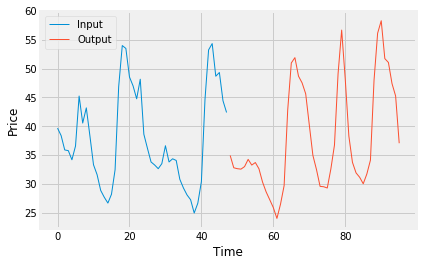

In [5]:
node = 133
start = 23
m = 48
n = 48

def plot_input_lstm(X, start, m, n, node):

    end_train = start + m
    end_test = end_train + n + 1
    t_in = np.arange(m)
    t_out = np.arange(n) + max(t_in) + 1
    input_y = X[node][start:end_train]
    output_y = X[node][end_train + 1:end_test]
    
    fig, ax = plt.subplots()
    ax.plot(t_in, input_y, label ='Input')
    ax.plot(t_out, output_y, label='Output')
    ax.set_ylabel('Price')
    ax.set_xlabel('Time')
    ax.legend()
    return fig, ax

fig, ax = plot_input_lstm(X, start, m, n, node)

The periodic nature of the data looks to be picked up with the 2 day input data, so I will use $m=48$ for my input into the LSTM (taking into account my limited computing power).

## Data Shaping

For data to be fed into an LSTM, it must be shaped correctly. The basics of this process is to take a single time series and loop through each day of the data, creating a single training instance similar to the graph above. For the keras implementation of LSTM that I will be using, the resulting dataset must then be reshaped again with numpy to be a valid input. Luckily, I have a pre-built function from college to do this for me :)

Also with LSTM specific preprocessing, standard preprocessing of test-train splitting, and Min Max scaling is going to be used in getting the data ready for the LSTM

### Test Train Split

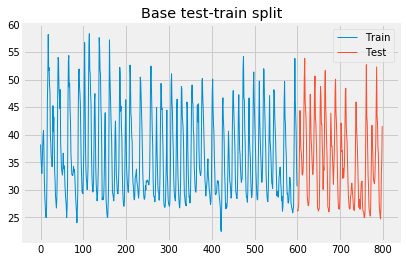

In [6]:
prices = X[node][0:800]
fraction_split = 0.75
train_stop = int(round(fraction_split*prices.shape[0]))
train = prices[0:train_stop]
test = prices[train_stop + 1:]

train_t = np.arange(train_stop)
test_t = np.arange(prices.shape[0] - train_stop - 1) + train_stop

fig, ax = plt.subplots()
ax.plot(train_t, train, label='Train')
ax.plot(test_t, test, label='Test')
ax.legend()
ax.set_title('Base test-train split')
plt.show()

### Min-Max Scaling

Neural Networks are extremely sensitive to data scaling, as their activation functions can reach very high values quite quickly. Becuase of this, it is appropriate to min-max scale data before training.

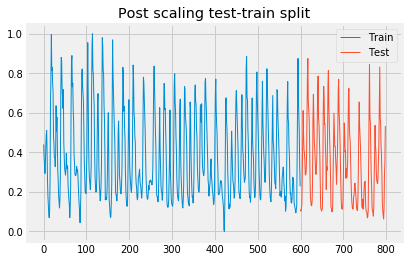

In [7]:
scaler = MinMaxScaler()
scaler.fit(train.reshape(-1,1))
train = scaler.transform(train.reshape(-1,1)).T[0]
test = scaler.transform(test.reshape(-1,1)).T[0]

fig, ax = plt.subplots()
ax.plot(train_t, train, label='Train')
ax.plot(test_t, test, label='Test')
ax.legend()
ax.set_title('Post scaling test-train split')
plt.show()

### LSTM Shaping

As described earlier, the scaled data is then shapped to be input similar to image data for CNN's.

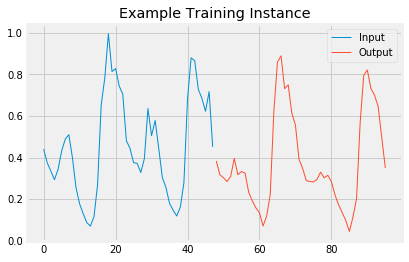

In [8]:
def split_training(timeseries, num_in, num_out):
    
    # intialize vectors for the input and output into the NN
    in_vec = []
    out_vec = []
    
    # determine how many training examples can be made
    num_instances = timeseries.shape[0] - num_in - num_out + 1
    
    # loop over the timeseries
    for i in range(num_instances):
        
        # input and output data for each instance
        data_inp = timeseries[i:num_in + i]
        data_out = timeseries[num_in + i:num_in + num_out+i]
        
        # store values
        in_vec.append(data_inp)
        out_vec.append(data_out)
    return np.array(in_vec), np.array(out_vec)

X_train, y_train = split_training(train, num_in=m, num_out=n)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test = split_training(test, num_in=m, num_out=n)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

ind = 0
train_ex = X_train[ind].T[0]
test_ex = y_train[ind]
t_train = np.arange(train_ex.shape[0])
t_test = np.arange(test_ex.shape[0]) + max(t_train) + 1

fig, ax = plt.subplots()
ax.plot(t_train, train_ex, label='Input')
ax.plot(t_test, test_ex, label='Output')
ax.legend()
ax.set_title('Example Training Instance')
plt.show()

In [9]:
X_test.shape

(104, 48, 1)

In [10]:
X_train.shape

(505, 48, 1)

# LSTM Modeling

## Base Case

Start with a simple LSTM definition. Two LSTM layers connected to a dense output, each with 100 nodes

In [16]:
# define model
features = 1
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, 
                               activation='relu', 
                               return_sequences=True, 
                               input_shape=(m, features)))
model.add(tf.keras.layers.LSTM(100, activation='relu'))
model.add(tf.keras.layers.Dense(n))
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 48, 100)           40800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 48)                4848      
Total params: 126,048
Trainable params: 126,048
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    validation_data=(X_test, y_test),
                    verbose=0
                   )

**wall clock time: 25m 28s**

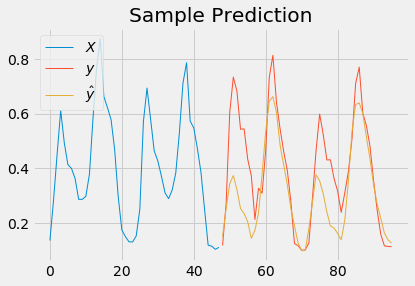

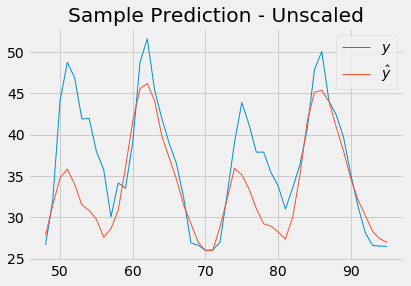

In [18]:
y_pred = model.predict(X_test)
y_pred_real = scaler.inverse_transform(y_pred)
y_test_real = scaler.inverse_transform(y_test)
ind = 3
fig, ax = plt.subplots()
ax.set_title('Sample Prediction')
ax.plot(t_train, X_test[ind].T[0], label='$X$')
ax.plot(t_test, y_test[ind], label='$y$')
ax.plot(t_test, y_pred[ind], label='$\hat{y}$')
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.set_title('Sample Prediction - Unscaled')
ax.plot(t_test, y_test_real[ind], label='$y$')
ax.plot(t_test, y_pred_real[ind], label='$\hat{y}$')
ax.legend()
plt.show()

## Performance Metrics - Unscaled

After inverse scaling the data, the results look pretty good! A mean percent error of only 8.4% is great for a stochastic time series.

In [19]:
mae = np.mean(np.abs(y_pred_real - y_test_real))
mape = np.mean(np.abs((y_pred_real - y_test_real) / y_test_real)*100)
print(f'Testing MAE: {mae:.2f}')
print(f'Testing MAPE: {mape:.2f}')

Testing MAE: 2.73
Testing MAPE: 8.40


## Training History

The need for a lot of epochs (typical of LSTMs) is quite evident in the training history graph below.

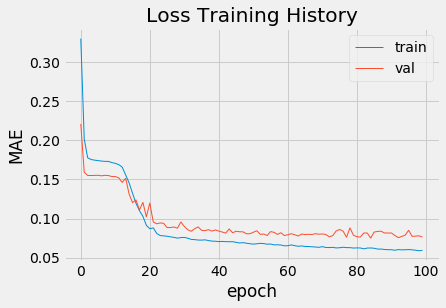

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Training History')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Hypter Tuning

### Depth Increase
Increasing the number of hidden layers yields the following result. Interestingly this does not work very well!

In [12]:
# define model
features = 1
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, 
                               activation='relu', 
                               return_sequences=True,
                               input_shape=(m, features)))
model.add(tf.keras.layers.LSTM(100, 
                               activation='relu', 
                               return_sequences=True))
model.add(tf.keras.layers.LSTM(100, 
                               activation='relu', 
                               return_sequences=True))
model.add(tf.keras.layers.LSTM(100, 
                               activation='relu', 
                               return_sequences=True))
model.add(tf.keras.layers.LSTM(100, activation='relu'))
model.add(tf.keras.layers.Dense(n))
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 48, 100)           40800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 48, 100)           80400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 48, 100)           80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 48, 100)           80400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 48)                4848      
Total params: 367,248
Trainable params: 367,248
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=100,
                    validation_data=(X_test, y_test),
                    verbose=0
                   )

Testing MAE: 3.93
Testing MAPE: 11.44


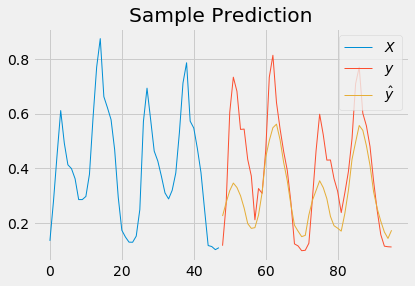

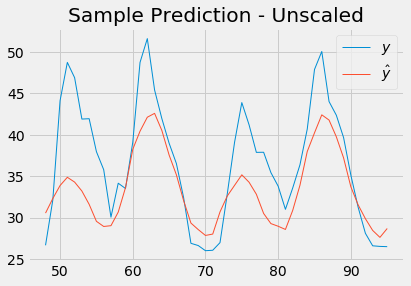

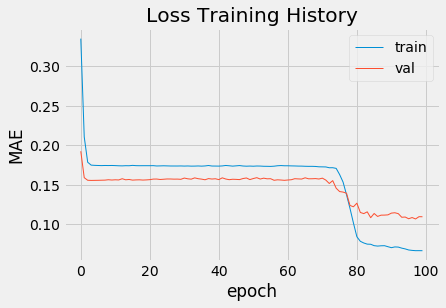

In [28]:
y_pred = model.predict(X_test)
y_pred_real = scaler.inverse_transform(y_pred)
y_test_real = scaler.inverse_transform(y_test)
ind = 3

mae = np.mean(np.abs(y_pred_real - y_test_real))
mape = np.mean(np.abs((y_pred_real - y_test_real) / y_test_real)*100)
print(f'Testing MAE: {mae:.2f}')
print(f'Testing MAPE: {mape:.2f}')

fig, ax = plt.subplots()
ax.set_title('Sample Prediction')
ax.plot(t_train, X_test[ind].T[0], label='$X$')
ax.plot(t_test, y_test[ind], label='$y$')
ax.plot(t_test, y_pred[ind], label='$\hat{y}$')
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.set_title('Sample Prediction - Unscaled')
ax.plot(t_test, y_test_real[ind], label='$y$')
ax.plot(t_test, y_pred_real[ind], label='$\hat{y}$')
ax.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Training History')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Wall Clock Time 1h 16m**

### Batch Sizing

Adjusting the batch size to be much smaller is very favorable for training the LSTM in this case (at least for training quickly). Note I terminated earlier because I was gettting impatient...

In [20]:
# define model
features = 1
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, 
                               activation='relu', 
                               return_sequences=True, 
                               input_shape=(m, features)))
model.add(tf.keras.layers.LSTM(100, activation='relu'))
model.add(tf.keras.layers.Dense(n))
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 48, 100)           40800     
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 48)                4848      
Total params: 126,048
Trainable params: 126,048
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size = 5,
                    validation_data=(X_test, y_test),
                    verbose=1
                   )

Train on 505 samples, validate on 104 samples
Epoch 1/100
505/505 [==============================] - 48s 95ms/sample - loss: 0.2031 - val_loss: 0.1555
Epoch 2/100
505/505 [==============================] - 46s 90ms/sample - loss: 0.1753 - val_loss: 0.1541
Epoch 3/100
505/505 [==============================] - 43s 86ms/sample - loss: 0.1712 - val_loss: 0.1453
Epoch 4/100
505/505 [==============================] - 64s 127ms/sample - loss: 0.1450 - val_loss: 0.1187
Epoch 5/100
505/505 [==============================] - 62s 123ms/sample - loss: 0.1151 - val_loss: 0.1240
Epoch 6/100
505/505 [==============================] - 49s 98ms/sample - loss: 0.1037 - val_loss: 0.1055
Epoch 7/100
505/505 [==============================] - 50s 99ms/sample - loss: 0.0898 - val_loss: 0.0991
Epoch 8/100
505/505 [==============================] - 47s 92ms/sample - loss: 0.0794 - val_loss: 0.1016
Epoch 9/100
505/505 [==============================] - 71s 140ms/sample - loss: 0.0791 - val_loss: 0.1001
Epoch 

KeyboardInterrupt: 

Testing MAE: 2.98
Testing MAPE: 9.16


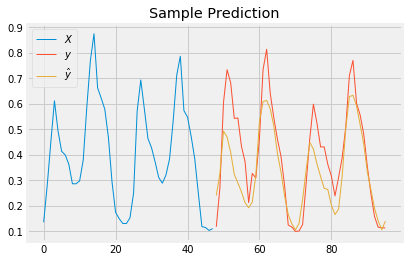

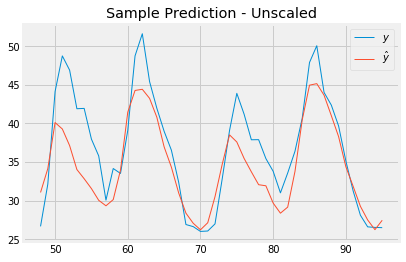

In [23]:
y_pred = model.predict(X_test)
y_pred_real = scaler.inverse_transform(y_pred)
y_test_real = scaler.inverse_transform(y_test)
ind = 3

mae = np.mean(np.abs(y_pred_real - y_test_real))
mape = np.mean(np.abs((y_pred_real - y_test_real) / y_test_real)*100)
print(f'Testing MAE: {mae:.2f}')
print(f'Testing MAPE: {mape:.2f}')

fig, ax = plt.subplots()
ax.set_title('Sample Prediction')
ax.plot(t_train, X_test[ind].T[0], label='$X$')
ax.plot(t_test, y_test[ind], label='$y$')
ax.plot(t_test, y_pred[ind], label='$\hat{y}$')
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.set_title('Sample Prediction - Unscaled')
ax.plot(t_test, y_test_real[ind], label='$y$')
ax.plot(t_test, y_pred_real[ind], label='$\hat{y}$')
ax.legend()
plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Loss Training History')
# plt.ylabel('MAE')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper right')
# plt.show()